<img src='img/logo.png' width=200>
<center>
    <br/>
    Otkrivanje zakonitosti u podacima 2019-2020
    <br/>
    Fakultet Organizacionih Nauka, 2020
    <br/>
    <h1>D1. Domaći zadatak 1</h1>
</center>

# Zahtevi domaćeg zadatka

1. Učitati i spojiti podatke
    1. Učitati podatke o transakcijama računa (folder `data` fajl `trans.csv`).
    2. Učitati podatke o korisnicima i povezati sa transakcijama (folder `data` fajl `client_accounts.csv`).
    3. Izračunati broj različitih računa koje korisnik poseduje.
    4. Napraviti pivot tabelu sume iznosa po tipu transakcije za svakog klijenta.
    5. Napraviti pivot tabelu sume iznosa po operaciji za svakog klijenta.
    6. Popuniti nedostajuće podatke.
    7. Rezultate iz C, D i E spojiti u jedan skup podataka nad kojim će se raditi klasterovanje od koraka 3.
2. RFM task
    1. Koristiti podatke o transakcijama računa (folder `data` fajl `trans.csv`).
    2. Recency da se računa kao broj dana od 10.05.2019. godine.
    3. Frequency kao broj transakcija.
    4. Monetary kao prosečna vrednost transakcije.
    5. Podeliti klijente u 5 grupa i koristeći rfm_group_mapping funkciju (predavanja Segmentacija korisnika).
    6. Prikazati prosečne vrednosti RFM kategorija po svakog grupi.
3. Normalizovati podatke na dva načina po izboru (npr. MaxMin, StandardScaler ili Normalizer). Za svaki od setova normalizovanih podataka uraditi sledeće:
    1. Identifikovati ekstremne vrednosti, karakterisati ih (zašto su ekstremne) i izbaciti iz skupa.
    2. Optimizovati K-means model po broju klastera koristeći SSE i Silhouette (dva optimizovana modela treba dobiti za svaku normalizaciju - ukupno četiri).
    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).
    5. Odgovoriti na pitanje koji klaster model je prema vašem mišljenju bolji (optimizovan na osnovu na siluet indeksa ili SSE) i zašto.
4. Kreirati hijerarhijski model klasterovanja.
    1. Prikazati denrogram.
    2. Odrediti granicu preseka na osnovu dendrograma i kreirati klastere (opisati klastere u Notebook-u i opisati zašto ste izabrali baš taj broj klastera).

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scikitplot as skplt
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Učitavanje i spajanje podataka

    1. Učitati podatke o transakcijama računa (folder `data` fajl `trans.csv`).

In [2]:
df_trans = pd.read_csv('data/trans.csv')
df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,2017-09-10 03:24:33,INCOME,DEPOSIT,700.0,700.0,NaN,NaN,NaN
1,171812,576,2017-09-14 03:24:33,INCOME,DEPOSIT,900.0,900.0,NaN,NaN,NaN
2,207264,704,2017-09-21 03:24:33,INCOME,DEPOSIT,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,2017-09-06 03:24:33,INCOME,DEPOSIT,600.0,600.0,NaN,NaN,NaN
4,579373,1972,2017-09-19 03:41:13,INCOME,DEPOSIT,400.0,400.0,NaN,NaN,NaN


    2. Učitati podatke o korisnicima i povezati sa transakcijama (folder `data` 
    fajl `client_accounts.csv`).

In [3]:
df_clients_acc = pd.read_csv('data/client_accounts.csv')
df_clients_acc.columns = ['account_id', 'client_id']

In [4]:
df = pd.merge(df_trans, df_clients_acc, how='left', on='account_id')

    3. Izračunati broj različitih računa koje korisnik poseduje.

In [5]:
client_df = df.groupby('client_id')['account_id'].nunique().reset_index()
client_df.head()

,client_id,account_id
0,1.0,1
1,2.0,2
2,3.0,2
3,4.0,1
4,5.0,1



    4. Napraviti pivot tabelu sume iznosa po tipu transakcije za svakog klijenta.

In [6]:
amount_per_type_df = df.pivot_table(index='client_id', columns='type', values=['amount'], aggfunc=np.sum) \
        .reset_index()
amount_per_type_df.head()

client_id    amount                       
type              CHOICE EXPENDITURE     INCOME
0          1.0       NaN    180854.0   194320.5
1          2.0  217442.0   1458946.6  1770112.5
2          3.0       NaN    228021.8   289831.0
3          4.0       NaN    299949.6   347617.5
4          5.0       NaN    561772.0   630267.9

In [7]:
amount_per_type_df.columns = ['client_id', 'choice_amt', 'expenditure_amt', 'income_amt']
amount_per_type_df.head()

,client_id,choice_amt,expenditure_amt,income_amt
0,1.0,NaN,180854.0,194320.5
1,2.0,217442.0,1458946.6,1770112.5
2,3.0,NaN,228021.8,289831.0
3,4.0,NaN,299949.6,347617.5
4,5.0,NaN,561772.0,630267.9


    5. Napraviti pivot tabelu sume iznosa po operaciji za svakog klijenta.

In [8]:
amount_per_ope_df = df.pivot_table(index='client_id', columns='operation', values='amount', aggfunc=np.sum) \
        .reset_index()
amount_per_ope_df.head()

operation,client_id,ACCOUNT TRANSFER,CARD,CHOICE,DEPOSIT,TRANSFER FROM ACCOUNT
0,1.0,98080.0,NaN,82774.0,25700.0,165555.0
1,2.0,618247.8,NaN,1058140.8,219389.0,1537936.0
2,3.0,136164.0,NaN,91857.8,1400.0,284125.0
3,4.0,185838.0,NaN,114111.6,900.0,340119.0
4,5.0,97600.0,5900.0,458272.0,623775.0,NaN


In [9]:
amount_per_ope_df.columns = ['client_id', 'account_transfer_amt', 'card_amt', 'choice_amt', 'deposit_amt', 'transfer_from_account_amt']
amount_per_ope_df.head()

,client_id,account_transfer_amt,card_amt,choice_amt,deposit_amt,transfer_from_account_amt
0,1.0,98080.0,NaN,82774.0,25700.0,165555.0
1,2.0,618247.8,NaN,1058140.8,219389.0,1537936.0
2,3.0,136164.0,NaN,91857.8,1400.0,284125.0
3,4.0,185838.0,NaN,114111.6,900.0,340119.0
4,5.0,97600.0,5900.0,458272.0,623775.0,NaN



    6. Popuniti nedostajuće podatke.

In [10]:
client_df.isnull().sum()

client_id     0
account_id    0
dtype: int64

In [11]:
amount_per_type_df.isnull().sum()

client_id             0
choice_amt         2483
expenditure_amt       0
income_amt            0
dtype: int64

In [12]:
amount_per_type_df.choice_amt.fillna(0, inplace=True)

In [13]:
amount_per_ope_df.isnull().sum()

client_id                       0
account_transfer_amt          533
card_amt                     2577
choice_amt                      0
deposit_amt                     0
transfer_from_account_amt    1922
dtype: int64

In [14]:
amount_per_ope_df.fillna(0, inplace=True)

    7. Rezultate iz C, D i E spojiti u jedan skup podataka nad kojim će se raditi klasterovanje od koraka 3.

In [15]:
pcdf = client_df.merge(amount_per_type_df,on='client_id').merge(amount_per_ope_df,on='client_id')
pcdf.head()

,client_id,account_id,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
0,1.0,1,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,165555.0
1,2.0,2,217442.0,1458946.6,1770112.5,618247.8,0.0,1058140.8,219389.0,1537936.0
2,3.0,2,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,284125.0
3,4.0,1,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,340119.0
4,5.0,1,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,0.0


In [16]:
pcdf = pcdf.drop(columns='account_id')
pcdf.set_index('client_id', inplace=True)
pcdf.head()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
client_id,,,,,,,,
1.0,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,165555.0
2.0,217442.0,1458946.6,1770112.5,618247.8,0.0,1058140.8,219389.0,1537936.0
3.0,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,284125.0
4.0,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,340119.0
5.0,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,0.0


## RFM Zadatak

    1. Koristiti podatke o transakcijama računa (folder `data` fajl `trans.csv`).
    2. Recency da se računa kao broj dana od 10.05.2019. godine.
    3. Frequency kao broj transakcija.
    4. Monetary kao prosečna vrednost transakcije.

In [17]:
DATE_TO = '2019-05-10 23:59:59'
CLUSTERING_FEATURES_COL = ['recency_raw', 'recency', 'frequency', 'monetary']

In [18]:
df[(df['date']<=DATE_TO)]

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,client_id
0,695247,2378,2017-09-10 03:24:33,INCOME,DEPOSIT,700.0,700.0,NaN,NaN,NaN,1956.0
1,171812,576,2017-09-14 03:24:33,INCOME,DEPOSIT,900.0,900.0,NaN,NaN,NaN,478.0
2,207264,704,2017-09-21 03:24:33,INCOME,DEPOSIT,1000.0,1000.0,NaN,NaN,NaN,586.0
3,1117247,3818,2017-09-06 03:24:33,INCOME,DEPOSIT,600.0,600.0,NaN,NaN,NaN,3158.0
4,579373,1972,2017-09-19 03:41:13,INCOME,DEPOSIT,400.0,400.0,NaN,NaN,NaN,1627.0
5,771035,2632,2017-09-12 03:41:13,INCOME,DEPOSIT,1100.0,1100.0,NaN,NaN,NaN,2174.0
6,452728,1539,2017-09-08 03:57:53,INCOME,DEPOSIT,600.0,600.0,NaN,NaN,NaN,1275.0
7,725751,2484,2017-09-07 03:57:53,INCOME,DEPOSIT,1100.0,1100.0,NaN,NaN,NaN,2046.0
8,497211,1695,2017-09-22 03:57:53,INCOME,DEPOSIT,200.0,200.0,NaN,NaN,NaN,NaN
9,232960,793,2017-09-08 03:57:53,INCOME,DEPOSIT,800.0,800.0,NaN,NaN,NaN,662.0


In [19]:
# filter only purchases happened before observation period end
filtered_df = df[(df['date']<=DATE_TO)]

In [20]:
# get staging df, with purchase count, average money spent and latest purchase
staging_df = filtered_df.groupby('client_id').agg({'trans_id':'count', 'date':'max' ,'amount':'mean'})
staging_df.reset_index(inplace=True)
staging_df.columns = ['client_id', 'trans_count', 'trans_date_max', 'amount_mean']
staging_df.head()

,client_id,trans_count,trans_date_max,amount_mean
0,1.0,239,2019-05-08 13:57:53,1569.767782
1,2.0,595,2019-05-09 16:44:33,5792.438824
2,3.0,270,2019-05-08 14:37:53,1917.973333
3,4.0,246,2019-05-06 15:37:53,2632.386585
4,5.0,130,2019-05-05 14:14:33,9169.537692


In [21]:
staging_df['observation_period_end_date']  = pd.to_datetime(DATE_TO)
staging_df['trans_date_max']  = pd.to_datetime(staging_df['trans_date_max'])

In [22]:
staging_df['recency_raw'] = (staging_df['observation_period_end_date'].subtract(staging_df['trans_date_max'])).dt.days
staging_df['recency'] = 1 / staging_df['recency_raw'] # inverting

staging_df.rename(columns={'trans_count':'frequency', 'amount_mean':'monetary'}, inplace=True)
columns_to_return = ['client_id'] + CLUSTERING_FEATURES_COL
rfm_df = staging_df[columns_to_return]
rfm_df.head()

,client_id,recency_raw,recency,frequency,monetary
0,1.0,2,0.50,239,1569.767782
1,2.0,1,1.00,595,5792.438824
2,3.0,2,0.50,270,1917.973333
3,4.0,4,0.25,246,2632.386585
4,5.0,5,0.20,130,9169.537692


    5. Podeliti klijente u 5 grupa i koristeći rfm_group_mapping funkciju (predavanja Segmentacija korisnika).

In [23]:
rfm_df['Recency'] = pd.qcut(rfm_df['recency'], q=3, labels=False, duplicates='drop') + 1

In [24]:
rfm_df.Recency.value_counts() #todo: use max-min scaler

1    1322
2    1076
3     841
Name: Recency, dtype: int64

In [25]:
rfm_df.Recency = rfm_df.Recency.replace({1: 1, 2: 2.5, 3:5})
rfm_df.Recency.value_counts() 

1.0    1322
2.5    1076
5.0     841
Name: Recency, dtype: int64

In [26]:
rfm_df['Frequency'] = pd.qcut(rfm_df['frequency'], q=5, labels=False) + 1
rfm_df['Monetary'] = pd.qcut(rfm_df['monetary'], q=5, labels=False) + 1
rfm_df.head()

,client_id,recency_raw,recency,frequency,monetary,Recency,Frequency,Monetary
0,1.0,2,0.50,239,1569.767782,2.5,3,1
1,2.0,1,1.00,595,5792.438824,5.0,5,4
2,3.0,2,0.50,270,1917.973333,2.5,3,1
3,4.0,4,0.25,246,2632.386585,1.0,3,2
4,5.0,5,0.20,130,9169.537692,1.0,2,5


In [27]:
rfm_df['RFM'] = rfm_df[['Recency', 'Frequency', 'Monetary']].agg('prod', axis=1)
rfm_df['RFM_Cluster'] = pd.cut(rfm_df['RFM'], bins=[0, 1, 8, 27, 64, 125], labels=False) + 1
rfm_df.head()

,client_id,recency_raw,recency,frequency,monetary,Recency,Frequency,Monetary,RFM,RFM_Cluster
0,1.0,2,0.50,239,1569.767782,2.5,3,1,7.5,2
1,2.0,1,1.00,595,5792.438824,5.0,5,4,100.0,5
2,3.0,2,0.50,270,1917.973333,2.5,3,1,7.5,2
3,4.0,4,0.25,246,2632.386585,1.0,3,2,6.0,2
4,5.0,5,0.20,130,9169.537692,1.0,2,5,10.0,3


In [28]:
def rfm_group_mapping(R, F, M):
    if (R == 1) & (F == 1) & (M == 1):
        return 'Lost'
    elif (R <= 2) & (F <= 2) & (M <= 2):
        return 'Hibernating'
    elif (R == 1) & (4 <= F <= 5) & (4 <= M <= 5):
        return 'Can\'t Lose Them'
    elif (1 <= R <= 2) & (2 <= F <= 5) & (2 <= M <= 5):
        return 'At Risk'
    elif (2 <= R <= 3) & (F <= 2) & (M <= 2):
        return 'About to Sleep'
    elif (2 <= R <= 3) & (2 <= F <= 3) & (2 <= M <= 3):
        return 'Need Attention'
    elif (3 <= R <= 4) & (F <= 1) & (M <= 1):
        return 'Promising'
    elif (4 <= R <= 5) & (F <= 1) & (M <= 1):
        return 'New Customers'
    elif (3 <= R <= 5) & (1 <= F <= 3) & (1 <= M <= 3):
        return 'Potential Loyal'
    elif (2 <= R <= 5) & (3 <= F <= 5) & (3 <= M <= 5):
        return 'Loyal'
    elif (4 <= R <= 5) & (4 <= F <= 5) & (4 <= M <= 5):
        return 'Champion'
    else: 
        return 'Other'

In [29]:
rfm_df['RFM_Group'] = rfm_df \
    .apply(lambda x: rfm_group_mapping(x['Recency'], x['Frequency'], x['Monetary']), axis=1)

In [30]:
rfm_df.RFM_Group.value_counts()

Other              915
Loyal              742
At Risk            562
Potential Loyal    235
Hibernating        204
About to Sleep     172
Can't Lose Them    156
Need Attention     119
Lost                93
New Customers       41
Name: RFM_Group, dtype: int64

    6. Prikazati prosečne vrednosti RFM kategorija po svakog grupi.

In [31]:
rfm_df.groupby('RFM_Group')[['recency_raw', 'frequency', 'monetary']].agg(['mean', 'max', 'min'])

recency_raw            frequency                monetary  \
                       mean  max min        mean   max  min         mean   
RFM_Group                                                                  
About to Sleep     2.000000    2   2  130.034884   199   24  2039.108506   
At Risk            3.508897    7   3  276.147687   850  128  5966.949841   
Can't Lose Them    3.551282    7   3  423.474359   914  303  8966.252214   
Hibernating        5.269608  123   3  120.357843   198   12  2319.860853   
Lost               9.602151  235   3   84.591398   127   36  1636.899579   
Loyal              1.549865    2   1  413.424528  1008  200  7905.583530   
Need Attention     2.000000    2   2  222.084034   296  128  3798.324088   
New Customers      1.000000    1   1   96.024390   127   51  1684.267017   
Other              2.333333   12   1  239.132240   867   11  5372.057120   
Potential Loyal    1.000000    1   1  192.795745   298   20  2925.600748   

                                            
                          max          min  
RFM_Group                                   
About to Sleep    3209.091608   920.614650  
At Risk          17862.352252  2105.892683  
Can't Lose Them  18962.825323  5694.439224  
Hibernating       3247.363924  1055.122436  
Lost              2085.773404   937.878632  
Loyal            19789.124138  3262.414699  
Need Attention    5680.795062  2124.894208  
New Customers     2103.289024  1007.260000  
Other            21062.613287   856.444321  
Potential Loyal   5662.453304   898.971831

## K-Means Klasterovanje

In [32]:
pcdf.head()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
client_id,,,,,,,,
1.0,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,165555.0
2.0,217442.0,1458946.6,1770112.5,618247.8,0.0,1058140.8,219389.0,1537936.0
3.0,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,284125.0
4.0,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,340119.0
5.0,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,0.0


### Otklanjanje izuzetaka


1. Identifikovati ekstremne vrednosti, karakterisati ih (zašto su ekstremne) i izbaciti iz skupa.

In [33]:
from scipy import stats

stats.zscore(pcdf)

array([[-0.41954103, -0.79326471, -0.80928515, ..., -0.75232267,
        -0.82025459, -0.03378273],
       [ 1.72929859,  1.20887115,  1.36487943, ...,  0.80657472,
        -0.54037477,  3.03773333],
       [-0.41954103, -0.71937621, -0.67750662, ..., -0.73780432,
        -0.85536799,  0.23158794],
       ...,
       [-0.41954103, -0.69863164, -0.63778949, ..., -0.5599593 ,
        -0.40167684, -0.40431018],
       [-0.12772489,  1.12735754,  1.0082593 , ...,  0.88226837,
        -0.851611  ,  2.9512109 ],
       [-0.41954103, -0.06501972, -0.13328707, ..., -0.34711734,
         0.12528572, -0.40431018]])

In [34]:
pcdf_full = pcdf
pcdf = pcdf.loc[(np.abs(stats.zscore(pcdf)) < 3).all(axis=1), :]

In [35]:
print(f'{str(pcdf_full.shape[0] - pcdf.shape[0])} outliers have been removed. Percentage: {str((pcdf_full.shape[0] - pcdf.shape[0]) / pcdf_full.shape[0])}')

303 outliers have been removed. Percentage: 0.09354739117011424


In [36]:
pcdf.head()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
client_id,,,,,,,,
1.0,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,165555.0
3.0,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,284125.0
4.0,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,340119.0
5.0,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,0.0
6.0,0.0,820144.4,892761.7,319628.0,0.0,500516.4,885084.0,0.0


Opservacije čija vrednost bar jedne osobine odstupa više od 3 standardne devijacije od srednje vrednosti su izuzeci. Uočeno je 303 takve opservacije, što je 9% seta.

### Skup podataka normalizovan StandardScalerom

Normalizovati podatke na dva načina po izboru (npr. MaxMin, StandardScaler ili Normalizer). 

In [37]:
from sklearn.preprocessing import StandardScaler

st_scaler = StandardScaler()
sdf = pd.DataFrame(st_scaler.fit_transform(pcdf), columns=pcdf.columns, index=pcdf.index)
sdf.head()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
client_id,,,,,,,,
1.0,-0.391733,-0.799081,-0.834880,-0.388010,-0.328628,-0.783284,-0.860262,0.213225
3.0,-0.391733,-0.700622,-0.654338,-0.117868,-0.328628,-0.762949,-0.903230,0.741801
4.0,-0.391733,-0.550479,-0.545105,0.234485,-0.328628,-0.713130,-0.904114,0.991418
5.0,-0.391733,-0.003948,-0.010816,-0.391415,0.415389,0.057328,0.197267,-0.524806
6.0,-0.391733,0.535382,0.485372,1.183500,-0.328628,0.151899,0.659320,-0.524806


    2. Optimizovati K-means model po broju klastera koristeći SSE i Silhouette (dva optimizovana modela treba dobiti za svaku normalizaciju - ukupno četiri).

#### Optimizacija metaparametra pomoću SSE

In [38]:
from sklearn.cluster import KMeans

sse = [KMeans(n_clusters=k, random_state=42).fit(sdf).inertia_ for k in range(1, 10)]

Text(0, 0.5, 'Suma kvadrata udaljenosti elementa od centroida')

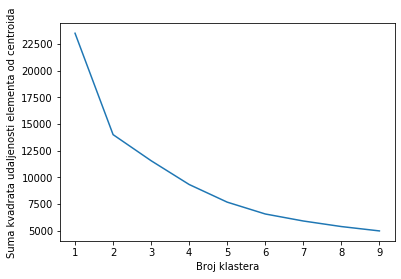

In [39]:
plt.plot(range(1, 10), sse)
plt.xlabel('Broj klastera')
plt.ylabel('Suma kvadrata udaljenosti elementa od centroida')

In [40]:
sse[2] #k=3

11555.19386440866

In [41]:
k=3
model = KMeans(n_clusters=k, random_state=42)

model.fit(sdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [42]:
model.cluster_centers_

array([[-0.33178704, -0.51524843, -0.52163384, -0.30369489, -0.13738515,
        -0.50053673, -0.45187459, -0.08391699],
       [ 0.68864593,  1.4555372 ,  1.4420057 ,  0.8725093 ,  0.3781575 ,
         1.3748978 ,  1.50850012, -0.42285909],
       [ 1.77889764,  0.63589566,  0.81766069,  0.29442018,  0.22433077,
         0.83298924, -0.72009887,  3.73835367]])

In [43]:
sdf_with_cluster = sdf.copy()
sdf_with_cluster['Cluster'] = model.predict(sdf)

sdf_with_cluster.groupby('Cluster').mean()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
Cluster,,,,,,,,
0,-0.331787,-0.515248,-0.521634,-0.303695,-0.137385,-0.500537,-0.451875,-0.083917
1,0.688646,1.455537,1.442006,0.872509,0.378158,1.374898,1.508500,-0.422859
2,1.778898,0.635896,0.817661,0.294420,0.224331,0.832989,-0.720099,3.738354


    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).

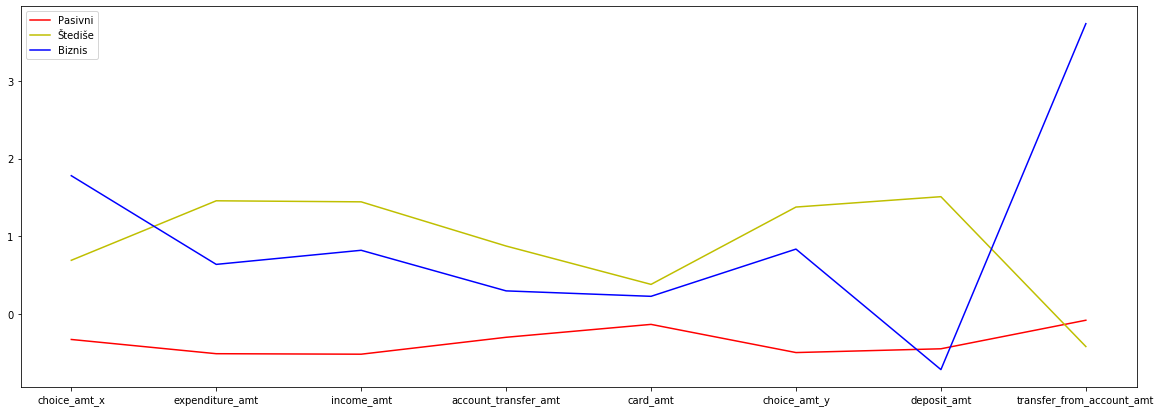

In [44]:
plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(model.cluster_centers_[0, :], c='r', label="Pasivni")
plt.plot(model.cluster_centers_[1, :], c='y', label="Štediše")
plt.plot(model.cluster_centers_[2, :], c='b', label="Biznis")

plt.xticks(list(range(sdf_with_cluster.shape[1] - 1)), sdf_with_cluster.columns[:-1])
plt.legend(loc="upper left")

plt.show()

In [45]:
model.inertia_

11555.19386440866

Prvi klaster (linija crvene boje) je karakterisan sa niskim iznosima svih tipova transakcija i to ga izdvaja od ostalih. Moglo bi se reći da korisnici iz ovog klastera koriste račun za uplate (npr. prijem plate) i ne koriste druge tipove transakcija. Ovu grupu možemo da nazovemo `Pasivni`.

Drugi klaster (linija žute boje) predstavlja ljude koji imaju visoke transakcije. Posebno ih karakteriše veoma visok iznos štednje, kao i visoka primanja i troškovi. To je grupa `Štediše`.

Treći klaster (linija plave boje) predstavlja ljude koje karakteriše visok nivo transfera na račun, dok su po ostalim tipovima transakcija prosečni. Takođe ih izdvaja i nizak nivo štednje. Nazvaćemo ih `Biznis`. 


In [46]:
model_eval_df = pd.DataFrame(columns=['norm', 'eval_method', "clusters", "sse", "silhoutte_score"])

In [47]:
model_eval_df.loc[len(model_eval_df)] = ['standard_scaler', 'sse', k, model.inertia_, silhouette_score(pcdf, model.labels_)]
model_eval_df

,norm,eval_method,clusters,sse,silhoutte_score
0,standard_scaler,sse,3,11555.193864,0.551638


#### Optimizacija metaparametra pomoću Silhoutte skora

In [48]:
silhouette_index = [silhouette_score(sdf, KMeans(n_clusters=k, random_state=42).fit_predict(sdf)) \
                    for k in range(2, 10)]

[0.4991016593516114, 0.5083141032296767, 0.41735858385094715, 0.4640324153102587, 0.39350175546492955, 0.34165844922525207, 0.3481863101029792, 0.32656879063075583]


Text(0, 0.5, 'Suma kvadrata udaljenosti elementa od centroida')

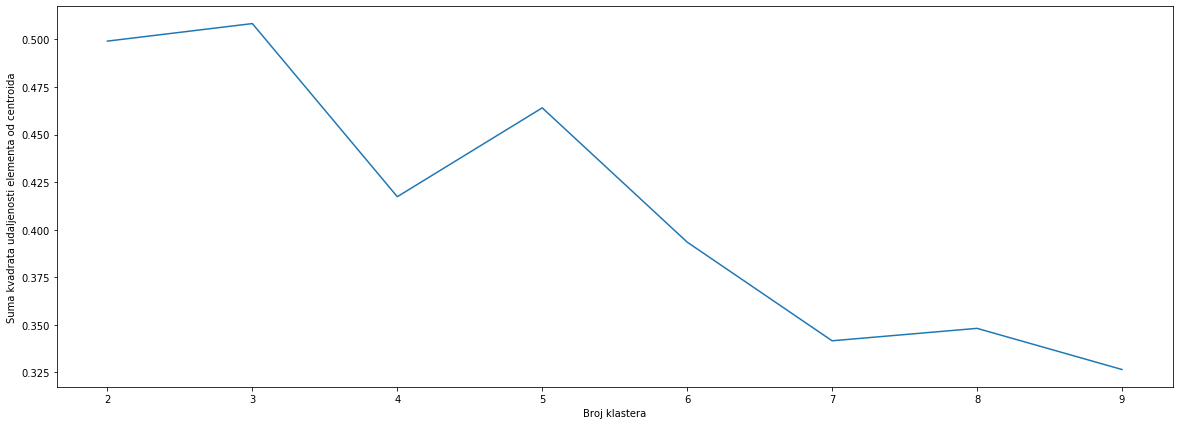

In [49]:
print(silhouette_index)
plt.plot(range(2, 10), silhouette_index)
plt.xlabel('Broj klastera')
plt.ylabel('Suma kvadrata udaljenosti elementa od centroida')

In [50]:
silhouette_index[3]  # k=4

0.4640324153102587

In [81]:
k=4
model = KMeans(n_clusters=4, random_state=42)
model.fit(sdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [82]:
model.cluster_centers_

array([[-3.53440105e-01, -6.68036291e-01, -6.69438371e-01,
        -4.54751934e-01, -2.46115293e-01, -6.17808871e-01,
        -6.18413753e-01, -1.02452977e-02,  1.45439216e-14],
       [ 1.54859561e+00,  2.04837788e+00,  2.08528360e+00,
         7.49372768e-01,  4.45919842e-01,  2.16820212e+00,
         2.10845589e+00, -4.23384936e-01,  2.00000000e+00],
       [ 1.77889764e+00,  6.35895655e-01,  8.17660688e-01,
         2.94420180e-01,  2.24330770e-01,  8.32989245e-01,
        -7.20098868e-01,  3.73835367e+00,  3.00000000e+00],
       [-1.50463656e-01,  5.38863115e-01,  4.96337718e-01,
         6.63126953e-01,  3.31038181e-01,  3.41777393e-01,
         6.25282061e-01, -4.15493556e-01,  1.00000000e+00]])

In [83]:
sdf_with_cluster = sdf
sdf_with_cluster['Cluster'] = model.predict(sdf)

sdf_with_cluster.groupby('Cluster').mean()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
Cluster,,,,,,,,
0,-0.353440,-0.668036,-0.669438,-0.454752,-0.246115,-0.617809,-0.618414,-0.010245
1,1.548596,2.048378,2.085284,0.749373,0.445920,2.168202,2.108456,-0.423385
2,1.778898,0.635896,0.817661,0.294420,0.224331,0.832989,-0.720099,3.738354
3,-0.150464,0.538863,0.496338,0.663127,0.331038,0.341777,0.625282,-0.415494


    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).

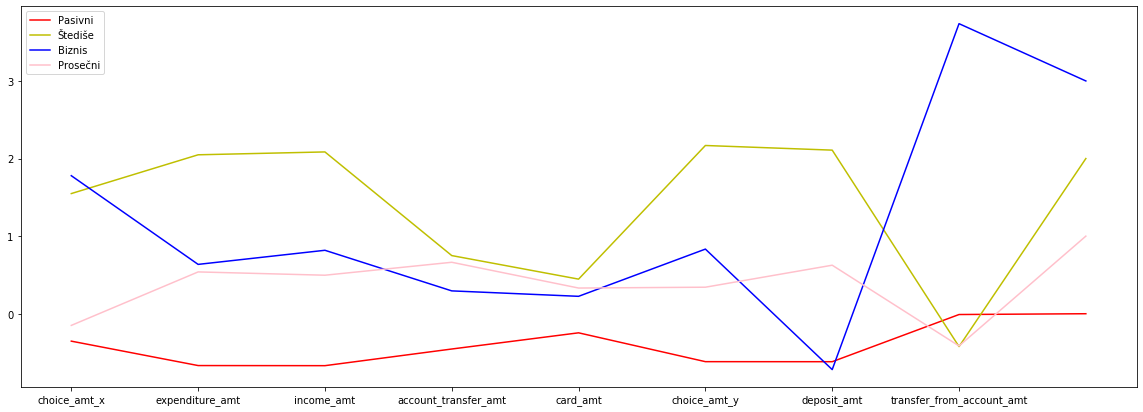

In [84]:
plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(model.cluster_centers_[0, :], c='r', label='Pasivni')
plt.plot(model.cluster_centers_[1, :], c='y', label='Štediše')
plt.plot(model.cluster_centers_[2, :], c='b', label='Biznis')
plt.plot(model.cluster_centers_[3, :], c='pink', label='Prosečni')

plt.xticks(list(range(sdf.shape[1] - 1)), sdf.columns[:-1])
plt.legend(loc="upper left")

plt.show()

Dobijeni su klasteri koji jako liče na prve rezultate, s tim što je izdvojen novi klaster koji predstavlja prosečne korisnike. S toga smo iskoristili prethodno definisana imena i dodajemo novi kao:

Četvrti klaster (linija roze boje) predstavlja ljude koji imaju umeren promet na računu. Njih možemo nazvati `Prosečni`.

In [55]:
model_eval_df.loc[len(model_eval_df)] = ['standard_scaler', 'silhoutte', k, model.inertia_, silhouette_score(sdf, model.labels_)]
model_eval_df

,norm,eval_method,clusters,sse,silhoutte_score
0,standard_scaler,sse,3,11555.193864,0.551638
1,standard_scaler,silhoutte,4,9329.710073,0.449800


### MinMax normalizovan skup podataka

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mdf = pd.DataFrame(scaler.fit_transform(pcdf), columns=pcdf.columns, index=pcdf.index)
mdf.head()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
client_id,,,,,,,,
1.0,0.0,0.074287,0.065387,0.143001,0.000000,0.034116,0.009629,0.109050
3.0,0.0,0.093813,0.101566,0.198528,0.000000,0.037924,0.000453,0.187152
4.0,0.0,0.123588,0.123455,0.270953,0.000000,0.047254,0.000264,0.224035
5.0,0.0,0.231972,0.230521,0.142302,0.119433,0.191542,0.235468,0.000000
6.0,0.0,0.338928,0.329952,0.466020,0.000000,0.209253,0.334141,0.000000


#### Optimizacija metaparametra pomoću SSE

In [57]:
from sklearn.cluster import KMeans

sse = [KMeans(n_clusters=k, random_state=42).fit(mdf).inertia_ for k in range(1, 10)]

Text(0, 0.5, 'Suma kvadrata udaljenosti elementa od centroida')

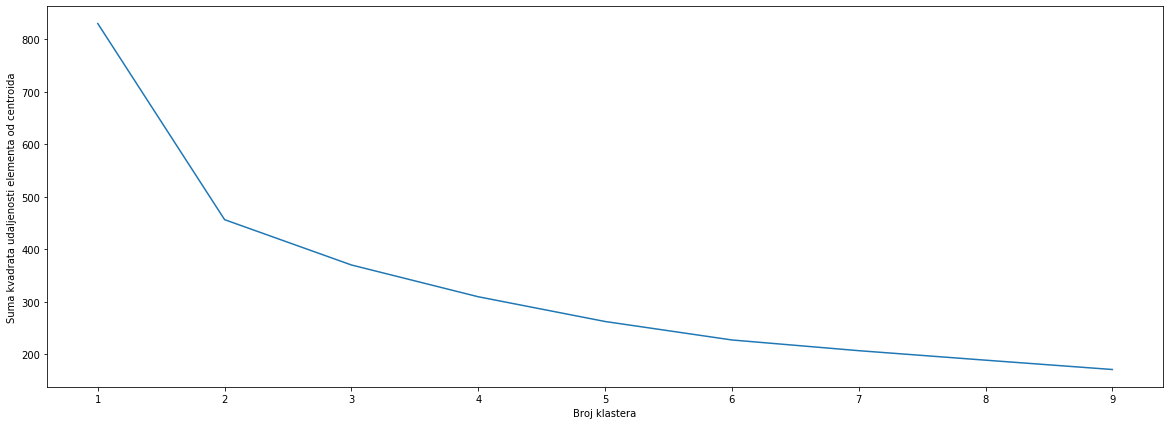

In [58]:
plt.plot(range(1, 10), sse)
plt.xlabel('Broj klastera')
plt.ylabel('Suma kvadrata udaljenosti elementa od centroida')

In [59]:
sse[1] # k=2

456.09334782518397

In [60]:
k=2
model = KMeans(n_clusters=k, random_state=42)

model.fit(mdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [61]:
model.cluster_centers_

array([[0.0186316 , 0.13382309, 0.13231489, 0.16019461, 0.03294693,
        0.09148246, 0.09391625, 0.07745661],
       [0.21850456, 0.51401152, 0.51804486, 0.40061271, 0.10906003,
        0.43474534, 0.47599967, 0.07779411]])

In [62]:
mdf_with_cluster = mdf.copy()
mdf_with_cluster['Cluster'] = model.predict(mdf)

mdf_with_cluster.groupby('Cluster').mean()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
Cluster,,,,,,,,
0,0.018632,0.133823,0.132315,0.160195,0.032947,0.091482,0.093916,0.077457
1,0.218505,0.514012,0.518045,0.400613,0.109060,0.434745,0.476000,0.077794


    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).

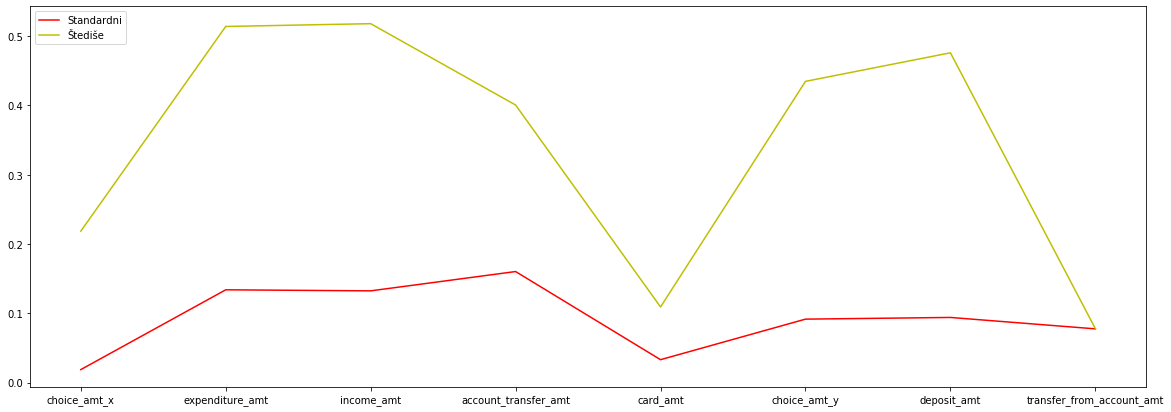

In [63]:
plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(model.cluster_centers_[0, :], c='r', label="Standardni")
plt.plot(model.cluster_centers_[1, :], c='y', label="Štediše")

plt.xticks(list(range(mdf_with_cluster.shape[1] - 1)), mdf_with_cluster.columns[:-1])
plt.legend(loc="upper left")

plt.show()

1. Crveni klaster predstavlja prosečne korisnike sa izraženim odlazećim transferom sa računa. Možemo ih zvati `Standardni`.
2. Žuti klaster su korisnici koji račun koriste za štednju i transfera sa računa, dok ređe plaćaju karticom. Ovaj klaster je tri puta manji od klastera standardnih korisnika. Oni su `Štediše`. 

In [64]:
model_eval_df.loc[len(model_eval_df)] = ['minmax', 'sse', k, model.inertia_, silhouette_score(mdf, model.labels_)]
model_eval_df

,norm,eval_method,clusters,sse,silhoutte_score
0,standard_scaler,sse,3,11555.193864,0.551638
1,standard_scaler,silhoutte,4,9329.710073,0.449800
2,minmax,sse,2,456.093348,0.514233


#### Optimizacija metaparametra pomoću Silhoutte skora

In [65]:
import scikitplot as skplt
from sklearn.metrics import silhouette_score

In [66]:
silhouette_index = [silhouette_score(mdf, KMeans(n_clusters=k, random_state=42).fit_predict(mdf)) \
                    for k in range(2, 10)]

Text(0, 0.5, 'Suma kvadrata udaljenosti elementa od centroida')

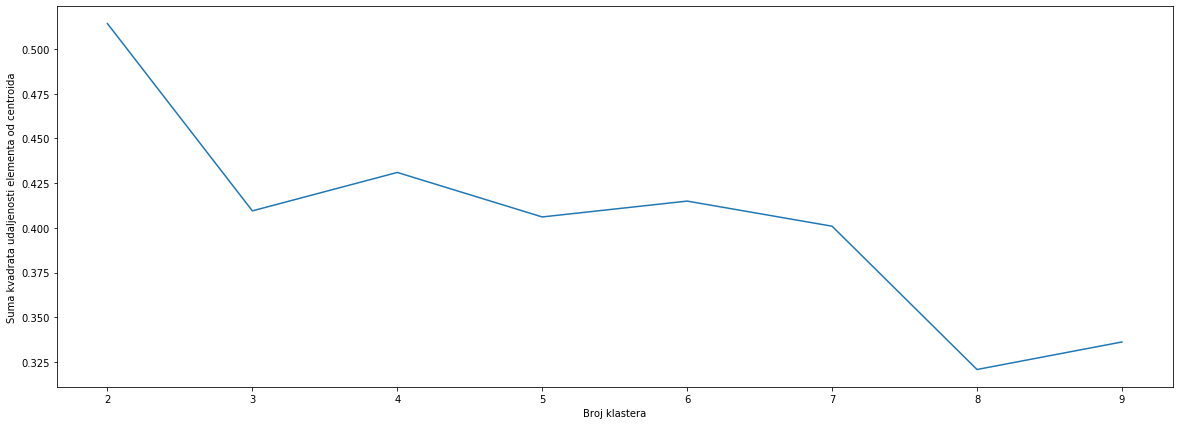

In [67]:
plt.plot(range(2, 10), silhouette_index)
plt.xlabel('Broj klastera')
plt.ylabel('Suma kvadrata udaljenosti elementa od centroida')

In [68]:
silhouette_index[2]  # k=3

0.4309861593987252

In [114]:
k=3
model = KMeans(n_clusters=3, random_state=42)
model.fit(mdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [70]:
model.cluster_centers_

array([[0.00927316, 0.10067801, 0.09926488, 0.12666096, 0.01462819,
        0.06658161, 0.06031522, 0.07898497],
       [0.09013223, 0.32874727, 0.32786572, 0.33959861, 0.10424491,
        0.24618014, 0.2775229 , 0.09501117],
       [0.31099891, 0.63056733, 0.63852467, 0.4082847 , 0.11500675,
        0.56384706, 0.62164638, 0.03227792]])

In [115]:
mdf_with_cluster = pd.DataFrame()
mdf_with_cluster = mdf.copy()
mdf_with_cluster['Cluster'] = model.predict(mdf)

mdf_with_cluster.groupby('Cluster').mean()

,choice_amt_x,expenditure_amt,income_amt,account_transfer_amt,card_amt,choice_amt_y,deposit_amt,transfer_from_account_amt
Cluster,,,,,,,,
0,0.009273,0.100678,0.099265,0.126661,0.014628,0.066582,0.060315,0.078985
1,0.090132,0.328747,0.327866,0.339599,0.104245,0.246180,0.277523,0.095011
2,0.310999,0.630567,0.638525,0.408285,0.115007,0.563847,0.621646,0.032278


    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).

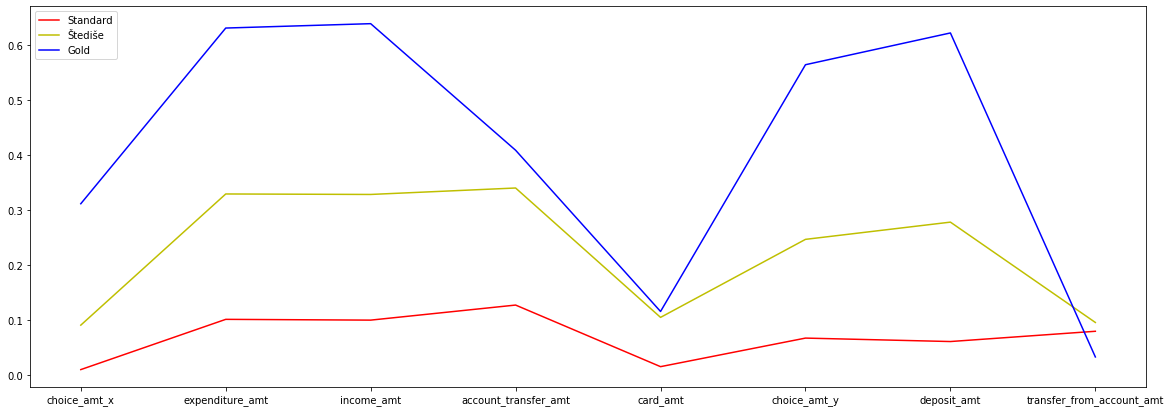

In [116]:
plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(model.cluster_centers_[0, :], c='r', label='Standard')
plt.plot(model.cluster_centers_[1, :], c='y', label='Štediše')
plt.plot(model.cluster_centers_[2, :], c='b', label='Gold')

plt.xticks(list(range(mdf_with_cluster.shape[1] - 1)), mdf_with_cluster.columns[:-1])
plt.legend(loc="upper left")

plt.show()

Vidimo da smo zadržali slične klastere, Standardne i Štediše, dok nam se odvojila i treća grupa koju možemo nazvati Gold, jer ih karakterišu daleko visoki iznosi transankcija.

In [74]:
model_eval_df.loc[len(model_eval_df)] = ['minmax', 'silhoutte', k, model.inertia_, silhouette_score(mdf, model.labels_)]

In [75]:
model_eval_df.sort_values(by=['silhoutte_score', 'sse'])

,norm,eval_method,clusters,sse,silhoutte_score
3,minmax,silhoutte,3,369.815690,0.409500
1,standard_scaler,silhoutte,4,9329.710073,0.449800
2,minmax,sse,2,456.093348,0.514233
0,standard_scaler,sse,3,11555.193864,0.551638


Iako po merama kvaliteta modela vidimo da je najbolji poslednji model koji smo napravili, kao finalni model biramo drugi model. 
Razlog za to je daleko bolja interpretabilnost. Pomoću poslednja dva modela dobili smo klastere koji međusobno jako liče, a najveća razlika je u iznosima transakcija (vidimo da su linije zapravo samo "podignute i preslikane"). Koristeći drugi model dobijamo klastere koji više govore o tipu korisnika i načinu na koji koristi svoje račune, pa je taj model daleko upotrebljiviji, zbog čega žrtvujemo malo tačnosti.

## Hijerarhijsko klasterovanje

Kreirati hijerarhijski model klasterovanja.
1. Prikazati denrogram.
2. Odrediti granicu preseka na osnovu dendrograma i kreirati klastere (opisati klastere u Notebook-u i opisati zašto ste izabrali baš taj broj klastera).

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(mdf, 'ward')

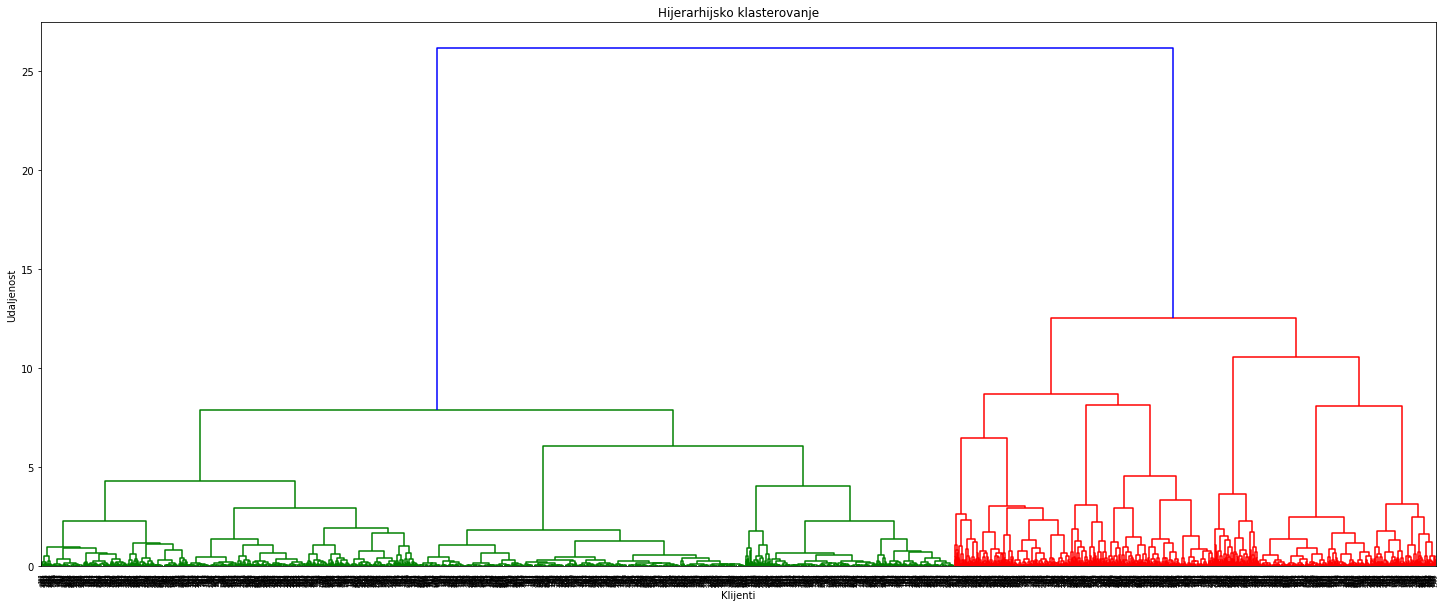

In [77]:
plt.figure(figsize=(25, 10))
plt.title('Hijerarhijsko klasterovanje')
plt.xlabel('Klijenti')
plt.ylabel('Udaljenost')

dendrogram(Z)

plt.show()

In [86]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=4, linkage='ward')
model.fit(mdf)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [87]:
silhouette_score(mdf, model.labels_)

0.3993200190365685

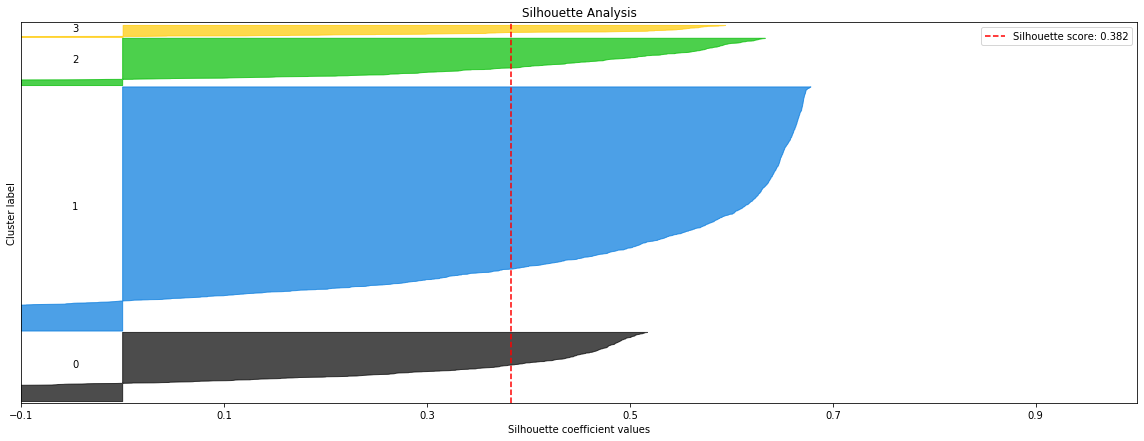

In [88]:
skplt.metrics.plot_silhouette(pcdf, model.labels_)

In [90]:
mdf_with_cluster = pd.DataFrame()
mdf_with_cluster = mdf.copy()
mdf_with_cluster['Cluster'] = model.labels_

In [108]:
mdf_agg_clusters = mdf_with_cluster.groupby('Cluster').mean()

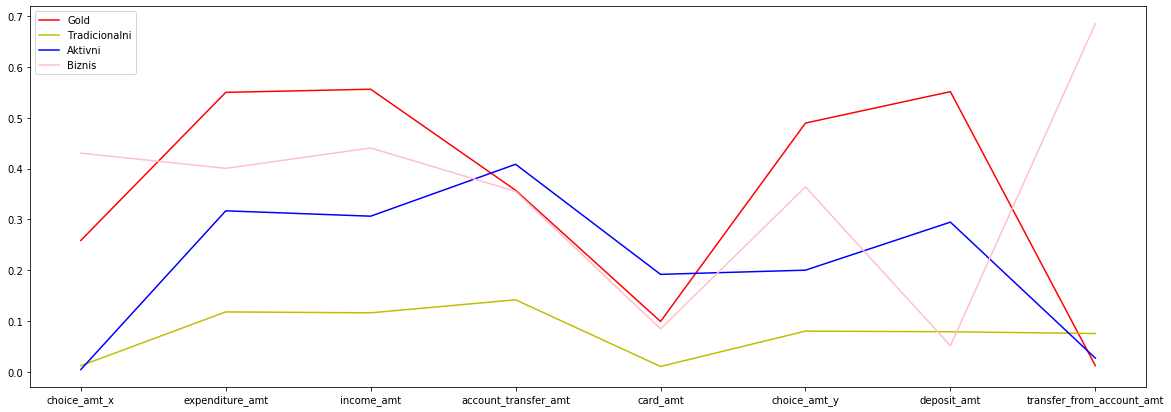

In [110]:
plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(mdf_agg_clusters.iloc[0, :], c='r', label='Gold')
plt.plot(mdf_agg_clusters.iloc[1, :], c='y', label='Tradicionalni')
plt.plot(mdf_agg_clusters.iloc[2, :], c='b', label='Aktivni')
plt.plot(mdf_agg_clusters.iloc[3, :], c='pink', label='Biznis')

plt.legend(loc="upper left")

plt.xticks(list(range(mdf_agg_clusters.shape[1])), mdf_agg_clusters.columns)

plt.show()

Prvi klaster (linija žute boje) čine korisnici koji najčešće koriste transfere sa i na račun, dok retko koriste karticu. Ovo je najveći klaster i iznosi transakcija nisu veliki. Možemo reći da su ovo `Tradicionalni` korisnici. 

Drugi klaster (linija plave boje) čine korisnici koji većinu svojih plaćanja vrše preko banke. Vidimo da imaju veliki transfer sa računa i koriste kartice. Takođe, vidimo viši novio depozita od prethedne grupe što potvrđuje pretpostavku da retko koriste gotovini. Ovaj klaster možemo nazvati `Aktivni`.

Treći klaster (linija roze boje) predstavlja ljude koje karakteriše visok nivo transfera na račun, dok su po ostalim tipovima transakcija prosečni. Takođe ih izdvaja i nizak nivo štednje. Nazvaćemo ih `Biznis`. 

Četvrtom klasteru (linija crvene boje) pripadaju korisnici sa veoma visokim primanjima. Oni takođe imaju i visoke iznose na drugim tipovima transakcija, a najviše na štednji. Nazvaćemo ih `Gold`. 